Name: Bor-Sheng Huang  
Github Username: borsheng  
USC ID: 9589131162  

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

### (a) Download the Anuran Calls (MFCCs) Data Set

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statistics
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import hamming_loss, calinski_harabasz_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from scipy.spatial import distance
from IPython.display import Image

In [2]:
df = pd.read_csv('../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')

# label encoding
le_f = preprocessing.LabelEncoder()
le_g = preprocessing.LabelEncoder()
le_s = preprocessing.LabelEncoder()
df['Family'] = le_f.fit_transform(df['Family'])
df['Genus'] = le_g.fit_transform(df['Genus'])
df['Species'] = le_s.fit_transform(df['Species'])

# separate features, labels and split the data
X = df.iloc[:, :-4].to_numpy()
y = df.iloc[:, -4:-1].to_numpy()
train_feature, test_feature, train_label, test_label = train_test_split(X, y, test_size=0.3, random_state=42)

### (b) Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:

#### i. Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem.

Exact match accuracy calculates subset accuracy, requiring the predicted labels to precisely match the true labels.

Hamming loss measures the proportion of incorrect labels to the total number of labels, providing a broader evaluation of label correctness.

#### ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation. You are welcome to try to solve the problem with both standardized and raw attributes and report the results.

In [3]:
# optimize hyperparameters
def optimize_hyperparameters(train_feature, train_label, alphas, gammas):
    best_loss = 1
    best_alpha = 0
    best_gamma = 0

    for alpha in alphas:
        for gamma in gammas:
            loss = 0
            kf = KFold(n_splits=10)

            for train_index, test_index in kf.split(train_feature):
                X_train, X_test = train_feature[train_index], train_feature[test_index]
                y_train, y_test = train_label[train_index], train_label[test_index]

                clf = SVC(kernel='rbf', random_state=42, gamma=gamma, C=alpha)
                ovr = OneVsRestClassifier(clf)
                ovr.fit(X_train, y_train)

                predicted = ovr.predict(X_test)
                loss += hamming_loss(y_test, predicted)

            if best_loss > loss / 10:
                best_loss = loss / 10
                best_alpha = alpha
                best_gamma = gamma

    return best_loss, best_alpha, best_gamma

alphas = np.logspace(1, 10, 10) / 10000
gammas = [x / 10.0 for x in range(1, 21, 2)]

f_loss, f_alpha, f_gamma = optimize_hyperparameters(train_feature, train_label[:, 0], alphas, gammas)
g_loss, g_alpha, g_gamma = optimize_hyperparameters(train_feature, train_label[:, 1], alphas, gammas)
s_loss, s_alpha, s_gamma = optimize_hyperparameters(train_feature, train_label[:, 2], alphas, gammas)

print(f'For Family label: loss = {f_loss}, C = {f_alpha}, and gamma = {f_gamma}')
print(f'For Genus label: loss = {g_loss}, C = {g_alpha}, and gamma = {g_gamma}')
print(f'For Species label: loss = {s_loss}, C = {s_alpha}, and gamma = {s_gamma}')

# testing
def evaluate_test_loss(X_train, y_train, X_test, y_test, gamma, C):
    clf = SVC(kernel='rbf', random_state=42, gamma=gamma, C=C)
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train, y_train)
    predicted = ovr.predict(X_test)
    return hamming_loss(y_test, predicted)

f_test_loss = evaluate_test_loss(train_feature, train_label[:, 0], test_feature, test_label[:, 0], f_gamma, f_alpha)
g_test_loss = evaluate_test_loss(train_feature, train_label[:, 1], test_feature, test_label[:, 1], g_gamma, g_alpha)
s_test_loss = evaluate_test_loss(train_feature, train_label[:, 2], test_feature, test_label[:, 2], s_gamma, s_alpha)

print('Testing:')
print(f'For Family label: test loss = {f_test_loss}')
print(f'For Genus label: test loss = {g_test_loss}')
print(f'For Species label: test loss = {s_test_loss}')

For Family label: loss = 0.00635275647701095, C = 10.0, and gamma = 1.9
For Genus label: loss = 0.008936855060115498, C = 10.0, and gamma = 1.7
For Species label: loss = 0.009135267758528196, C = 10.0, and gamma = 1.5
Testing:
For Family label: test loss = 0.00555812876331635
For Genus label: test loss = 0.009263547938860583
For Species label: test loss = 0.009263547938860583


#### iii. Repeat 1(b)ii with L1-penalized SVMs. Remember to standardize the attributes. Determine the weight of the SVM penalty using 10 fold cross validation.

In [4]:
warnings.simplefilter("ignore", ConvergenceWarning)

# standardize the features
scaler = StandardScaler()
std_train_feature = scaler.fit_transform(train_feature)

# optimize hyperparameters for L1-penalized SVM
def optimize_hyperparameters_l1(train_feature, train_label, alphas):
    best_loss = 1
    best_alpha = 0

    for alpha in alphas:
        loss = 0
        kf = KFold(n_splits=10)

        for train_index, test_index in kf.split(train_feature):
            X_train, X_test = train_feature[train_index], train_feature[test_index]
            y_train, y_test = train_label[train_index], train_label[test_index]

            clf = LinearSVC(penalty='l1', random_state=42, C=alpha, verbose=0, max_iter=10000, dual=False)
            ovr = OneVsRestClassifier(clf)
            ovr.fit(X_train, y_train)

            predicted = ovr.predict(X_test)
            loss += hamming_loss(y_test, predicted)

        if best_loss > loss / 10:
            best_loss = loss / 10
            best_alpha = alpha

    return best_loss, best_alpha

alphas = np.logspace(1, 10, 10) / 10000
f_loss, f_alpha = optimize_hyperparameters_l1(std_train_feature, train_label[:, 0], alphas)
g_loss, g_alpha = optimize_hyperparameters_l1(std_train_feature, train_label[:, 1], alphas)
s_loss, s_alpha = optimize_hyperparameters_l1(std_train_feature, train_label[:, 2], alphas)

print(f'For Family label: loss = {f_loss} and C = {f_alpha}')
print(f'For Genus label: loss = {g_loss} and C = {g_alpha}')
print(f'For Species label: loss = {s_loss} and C = {s_alpha}')

# testing
def evaluate_test_loss_l1(X_train, y_train, X_test, y_test, C):
    clf = LinearSVC(penalty='l1', random_state=42, C=C, verbose=0, max_iter=10000, dual=False)
    ovr = OneVsRestClassifier(clf)
    ovr.fit(X_train, y_train)
    predicted = ovr.predict(X_test)
    return hamming_loss(y_test, predicted)

f_test_loss = evaluate_test_loss_l1(train_feature, train_label[:, 0], test_feature, test_label[:, 0], f_alpha)
g_test_loss = evaluate_test_loss_l1(train_feature, train_label[:, 1], test_feature, test_label[:, 1], g_alpha)
s_test_loss = evaluate_test_loss_l1(train_feature, train_label[:, 2], test_feature, test_label[:, 2], s_alpha)

print('Testing:')
print(f'For Family label: test loss = {f_test_loss}')
print(f'For Genus label: test loss = {g_test_loss}')
print(f'For Species label: test loss = {s_test_loss}')

For Family label: loss = 0.05937075956956672 and C = 10.0
For Genus label: loss = 0.04765533781438354 and C = 10.0
For Species label: loss = 0.039714096374136136 and C = 10.0
Testing:
For Family label: test loss = 0.07271885132005558
For Genus label: test loss = 0.05789717461787865
For Species label: test loss = 0.03890690134321445


#### iv. Repeat iii. by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

In [5]:
# apply SMOTE
smote = SMOTE(random_state=42)
X_train_f, y_train_f = smote.fit_resample(std_train_feature, train_label[:,0])
X_train_g, y_train_g = smote.fit_resample(std_train_feature, train_label[:,1])
X_train_s, y_train_s = smote.fit_resample(std_train_feature, train_label[:,2])

f_loss, f_alpha = optimize_hyperparameters_l1(X_train_f, y_train_f, alphas)
g_loss, g_alpha = optimize_hyperparameters_l1(X_train_g, y_train_g, alphas)
s_loss, s_alpha = optimize_hyperparameters_l1(X_train_s, y_train_s, alphas)

print(f'For Family label with SMOTE: loss = {f_loss} and C = {f_alpha}')
print(f'For Genus label with SMOTE: loss = {g_loss} and C = {g_alpha}')
print(f'For Species label with SMOTE: loss = {s_loss} and C = {s_alpha}')

# testing
std_test_feature = scaler.fit_transform(test_feature)

f_test_loss = evaluate_test_loss_l1(X_train_f, y_train_f, std_test_feature, test_label[:, 0], f_alpha)
g_test_loss = evaluate_test_loss_l1(X_train_g, y_train_g, std_test_feature, test_label[:, 1], g_alpha)
s_test_loss = evaluate_test_loss_l1(X_train_s, y_train_s, std_test_feature, test_label[:, 2], s_alpha)

print('Testing with SMOTE:')
print(f'For Family label: test loss = {f_test_loss}')
print(f'For Genus label: test loss = {g_test_loss}')
print(f'For Species label: test loss = {s_test_loss}')

For Family label with SMOTE: loss = 0.055234608082451855 and C = 10.0
For Genus label with SMOTE: loss = 0.07476453881726666 and C = 100.0
For Species label with SMOTE: loss = 0.16142214957090315 and C = 1000.0
Testing with SMOTE:
For Family label: test loss = 0.08985641500694766
For Genus label: test loss = 0.0856878184344604
For Species label: test loss = 0.04353867531264474


Conclusions:   
In this problem, Support Vector Machines (SVMs) were employed to classify anuran calls into family, genus, and species labels. Gaussian kernels yielded optimal performance with penalties (C) set to 10.0 and kernel widths (gamma) of 1.9, 1.7, and 1.5 for family, genus, and species labels, respectively. The L1-penalized SVMs, after attribute standardization, exhibited losses of 0.059, 0.048, and 0.040 for family, genus, and species labels, with C values fixed at 10.0. The introduction of Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance resulted in varied C values (10.0, 100.0, 1000.0) and increased testing losses. Overall, the models demonstrate effective label classification, with some sensitivity to class imbalance mitigation.

### 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set. Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.

#### (a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.
#### (b) In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.
#### (c) Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss between the true labels and the labels assigned by clusters.

In [6]:
df = pd.read_csv('../data/Anuran Calls (MFCCs)/Frogs_MFCCs.csv')
raw_data = df.iloc[:, :-4].to_numpy()

hamming_distances = []
hamming_scores = []
hamming_losses = []

num_iterations = 50

warnings.simplefilter("ignore", category=FutureWarning)

for _ in range(num_iterations):
    # (a): use k-means clustering
    results = {}
    for i in range(2, 51):
        kmeans = KMeans(n_clusters=i, random_state=42)
        predicted = kmeans.fit_predict(raw_data)
        index = calinski_harabasz_score(raw_data, predicted)
        results[i] = index

    best_k = max(results, key=results.get)

    # (b): determine which family is majority
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    predicted = kmeans.fit_predict(raw_data)

    majority_labels = []
    for label in range(best_k):
        cluster_mask = (predicted == label)
        majority_labels.append({
            'Family': df['Family'][cluster_mask].mode().values[0],
            'Genus': df['Genus'][cluster_mask].mode().values[0],
            'Species': df['Species'][cluster_mask].mode().values[0]
        })

    # (c): calculate the average Hamming distance, score, and loss
    df['Family_pre'] = [majority_labels[label]['Family'] for label in predicted]
    df['Genus_pre'] = [majority_labels[label]['Genus'] for label in predicted]
    df['Species_pre'] = [majority_labels[label]['Species'] for label in predicted]

    true_labels = df[['Family', 'Genus', 'Species']].to_numpy()
    predicted_labels = df[['Family_pre', 'Genus_pre', 'Species_pre']].to_numpy()
    
    hamming_distances.append(np.sum(np.not_equal(true_labels, predicted_labels))/float(predicted_labels.size)*3)
    hamming_scores.append(1-np.sum(np.not_equal(true_labels, predicted_labels))/float(predicted_labels.size))
    hamming_losses.append(np.sum(np.not_equal(true_labels, predicted_labels))/float(predicted_labels.size))

# calculate average and standard deviation
avg_hamming_distance = np.mean(hamming_distances)
avg_hamming_score = np.mean(hamming_scores)
avg_hamming_loss = np.mean(hamming_losses)
std_dev_hamming_distance = np.std(hamming_distances)
std_dev_hamming_score = np.std(hamming_scores)
std_dev_hamming_loss = np.std(hamming_losses)

print(f"Average Hamming Distance: {avg_hamming_distance}")
print(f"Average Hamming Score: {avg_hamming_score}")
print(f"Average Hamming Loss: {avg_hamming_loss}")
print(f"Standard Deviation of Hamming Distance: {std_dev_hamming_distance}")
print(f"Standard Deviation of Hamming Score: {std_dev_hamming_score}")
print(f"Standard Deviation of Hamming Loss: {std_dev_hamming_loss}")

Average Hamming Distance: 0.895621959694232
Average Hamming Score: 0.7014593467685891
Average Hamming Loss: 0.29854065323141077
Standard Deviation of Hamming Distance: 1.1102230246251565e-16
Standard Deviation of Hamming Score: 1.1102230246251565e-16
Standard Deviation of Hamming Loss: 5.551115123125783e-17


## 3. ISLR 12.6.2

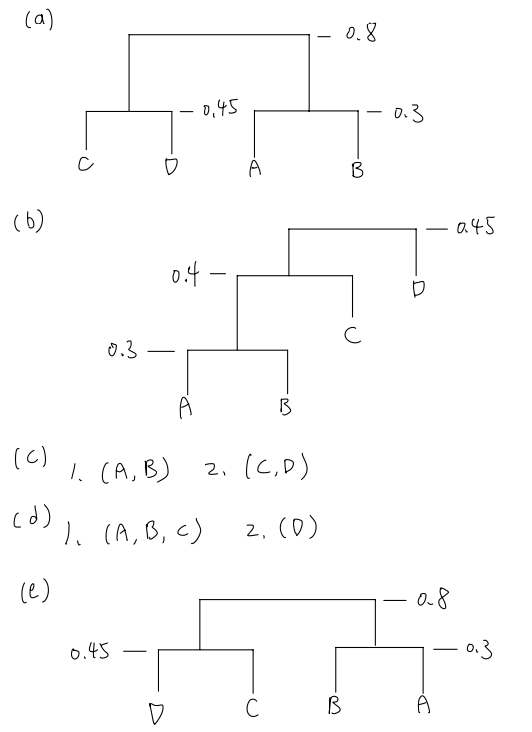

In [7]:
Image(filename='./ISLR.png')